# Exercise 5

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
import scipy.stats as stats

import sys
sys.path.insert(0, '..')
from multiprocess import mp_pandas_obj

## Snippets

### SNIPPET 5.1 WEIGHTING FUNCTION

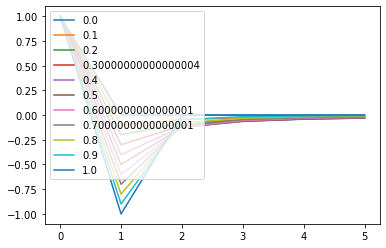

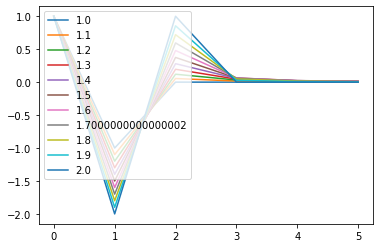

In [2]:
def getWeights(d,size):
    # thres>0 drops insignificant weights
    w=[1.]
    for k in range(1,size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w 

def plotWeights(dRange,nPlots,size):
    w=pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        w_=getWeights(d,size=size)
        w_=pd.DataFrame(w_,index=range(w_.shape[0])[::-1],columns=[d])
        w=w.join(w_,how='outer')
    ax=w.plot()
    ax.legend(loc='upper left')
    return

if __name__=='__main__':
    plotWeights(dRange=[0,1],nPlots=11,size=6)
    plotWeights(dRange=[1,2],nPlots=11,size=6)

## SNIPPET 5.2 STANDARD FRACDIFF (EXPANDING WINDOW)

In [3]:
def fracDiff(series,d,thres=.01):
    """
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped.
    Note 2: d can be any positive fractional, not necessairly bounded [0, 1].
    """
    #1) Compute weights for the longest series
    w=getWeights(d,series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshld
    w_=np.cumsum(abs(w))
    w_/=w_[-1]
    skip=w_[w_>thres].shape[0]
    #3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF, df_=series[[name]].fillna(method="ffill").dropna(),pd.Series()
        for iloc in range(skip,seriesF.shape[0]):
            loc=seriesF.index[iloc]
            if not np.isfinite(series.loc[loc,name]):continue #exclude NAs
            df_[loc]=np.dot(w[-(iloc+1):,:].T,seriesF.loc[:loc])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

def fracDiff(series, d, thres=0.01):
    '''
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped
    Note 2: d can be any positive fractional, not necessarily
        bounded between [0,1]
    '''
    #1) Compute weights for the longest series
    w=getWeights(d, series.shape[0])
    #bp()
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_=np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF, df_=series[[name]].fillna(method='ffill').dropna(), pd.Series(dtype=float)
        for iloc in range(skip, seriesF.shape[0]):
            loc=seriesF.index[iloc]
            test_val = series.loc[loc,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc]=np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
            except:
                continue
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df
    

## SNIPPET 5.3 THE NEW FIXED-WIDTH WINDOW FRACDIFF METHOD

In [4]:
def getWeights_FFD(d,thres):
    # thres>0 drops insignificant weights
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_)
        k+=1
    w=np.array(w[::-1]).reshape(-1,1)
    return w


def fracDiff_FFD(series,d,thres=1e-5):
    '''
    Constant width window (new solution)
    Note 1: thres determines the cut-off weight for the window
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    #1) Compute weights for the longest series
    w=getWeights_FFD(d,thres)
    width=len(w)-1
    #2) Apply weights to values
    df={}
    for name in series.columns:
        print(f"starting {name} in {series.columns}")
        seriesF =series[[name]].fillna(method='ffill').dropna()
        df_=pd.Series()
        print(f"inner loop: starting {range(width,seriesF.shape[0])}")
        for iloc1 in range(width,seriesF.shape[0]):
            loc0,loc1=seriesF.index[iloc1-width],seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1,name]):continue # exclude NAs
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
        print("Finished inner loop")
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

# def fracDiff_FFD(series,d,thres=1e-5):
#     # Constant width window (new solution)
#     w = getWeights_FFD(d,thres)
#     width = len(w)-1
#     df={}
#     for name in series.columns:
#         seriesF, df_=series[[name]].fillna(method='ffill').dropna(), pd.Series()
#         for iloc1 in range(width,seriesF.shape[0]):
#             loc0,loc1=seriesF.index[iloc1-width], seriesF.index[iloc1]
#             test_val = series.loc[loc1,name] # must resample if duplicate index
#             if isinstance(test_val, (pd.Series, pd.DataFrame)):
#                 test_val = test_val.resample('1m').mean()
#             if not np.isfinite(test_val).any(): continue # exclude NAs
#             #print(f'd: {d}, iloc1:{iloc1} shapes: w:{w.T.shape}, series: {seriesF.loc[loc0:loc1].notnull().shape}')
#             try:
#                 df_.loc[loc1]=np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
#             except:
#                 continue
#         df[name]=df_.copy(deep=True)
#     df=pd.concat(df,axis=1)
#     return df

## SNIPPET 5.4 FINDING THE MINIMUM D VALUE THAT PASSES THE ADF TEST

In [5]:
def plotMinFFD():
    path,instName='./','ES1_Index_Method12' 
    out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr']) 
    df0=pd.read_csv(path+instName+'.csv',index_col=0,parse_dates=True)
    for d in np.linspace(0,1,11):
        df1=np.log(df0[['Close']]).resample('1D').last() # downcast to daily obs 
        df2=fracDiff_FFD(df1,d,thres=.01) 
        corr=np.corrcoef(df1.loc[df2.index,'Close'],df2['Close'])[0,1] 
        df2=adfuller(df2['Close'],maxlag=1,regression='c',autolag=None) 
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # with critical value
    out.to_csv(path+instName+'_testMinFFD.csv') 
    out[['adfStat','corr']].plot(secondary_y='adfStat')
    mpl.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted') 
    mpl.savefig(path+instName+'_testMinFFD.png')
    return


## 1) Generate a time series from an IID Gaussian random process. This is a memory-less, stationary series:

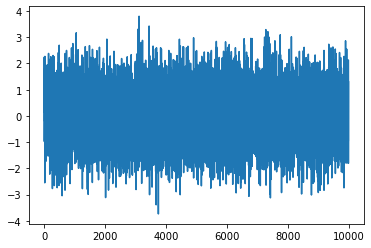

In [6]:
np.random.seed(0)

N = 10_000
s = pd.Series(np.random.randn(N))
s.plot();

### a) Compute the ADF statistic on this series. What is the p-value?

In [7]:
# Lambda functions? 
adf = lambda s: adfuller(s)
p_val = lambda s: adfuller(s)[1]

In [8]:
adf_statistic = adf(s)
print(f"p value is {adf_statistic[1]}")
adf_statistic

p value is 0.0


(-99.49026786274273,
 0.0,
 0,
 9999,
 {'1%': -3.4310041633725734,
  '5%': -2.861829101294412,
  '10%': -2.566923883481157},
 28010.559107207227)

### b) Compute the cumulative sum of the observations. This is a non-stationary series without memory.

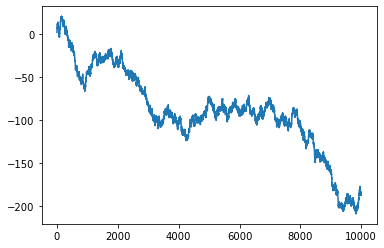

In [9]:
cmsm = pd.Series(s).cumsum()
cmsm.plot();

#### i) What is the order of integration of this cumulative series?

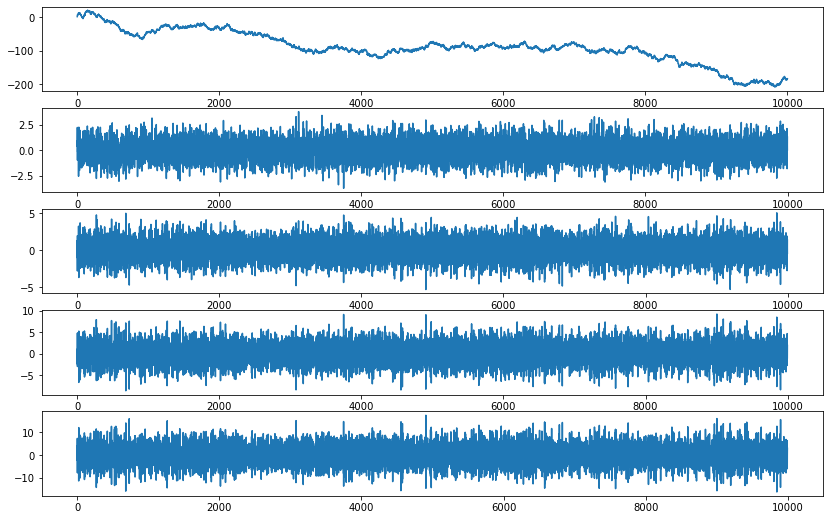

In [10]:
fig, (ax, ax1, ax2, ax3, ax4) = plt.subplots(5, figsize=(14, 9))

ax.plot(np.diff(cmsm, 0))
ax1.plot(np.diff(cmsm, 1))
ax2.plot(np.diff(cmsm, 2))
ax3.plot(np.diff(cmsm, 3))
ax4.plot(np.diff(cmsm, 4))

In [11]:
orders = [0, 1, 2, 3, 4]
for o in orders:
    diff_ = np.diff(cmsm,o)
    print('='*27)
    print(f'order: {o}, pVal: {p_val(diff_)}')

order: 0, pVal: 0.7653146162853299
order: 1, pVal: 0.0
order: 2, pVal: 0.0
order: 3, pVal: 0.0
order: 4, pVal: 0.0


#### ii) Compute the ADF statistic on this series. What is the p-value?

In [12]:
p_val(cmsm)

0.7653146162853299

### c) Differentiate the series twice. What is the p-value of this over-differentiated series?

In [13]:
diff_ = np.diff(cmsm,2)
p_val(diff_)

0.0

## 2) Generate a time series that follows a sinusoidal function. This is a stationary series with memory.

<AxesSubplot:>

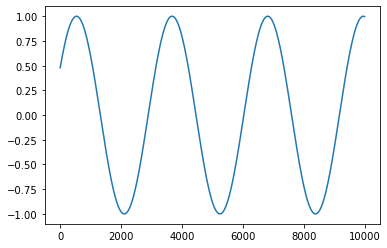

In [14]:
np.random.seed(0)

rand = np.random.random(N)

idx = np.linspace(0,10, N)
s = pd.Series(1*np.sin(2.*idx + .5))
s.plot()

### a) Compute the ADF statistic on this series. What is the p-value?

In [15]:
p_val(s)

0.0

### b) Shift every observation by the same positive value. Compute the cumulative sum of the observations. This is a non-stationary series with memory.

<AxesSubplot:>

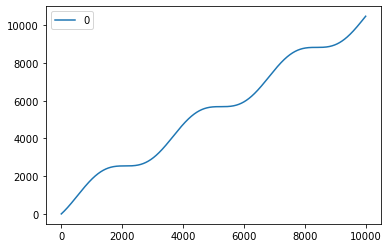

In [16]:
s_ = (s + 1).cumsum().to_frame()
s_.plot()

In [17]:
s_

,0
0,1.479426
1,2.960605
2,4.443538
3,5.928221
4,7.414652
...,...
9995,10471.274929
9996,10473.272219
9997,10475.269359
9998,10477.266346


#### i) Compute the ADF statistic on this series. What is the p-value?

In [18]:
adf(s_.dropna())

(26.109856678967738,
 1.0,
 24,
 9975,
 {'1%': -3.4310057377047953,
  '5%': -2.8618297969788036,
  '10%': -2.5669242537948884},
 -542797.0709216392)

In [19]:
p_val(s_)

1.0

#### ii) Apply an expanding window fracdiff, with $𝜏 = 1E − 2$. For what minimum $d$ value do you get a p-value below 5%?

In [20]:
cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
out = pd.DataFrame(columns=cols)
for d in np.linspace(0,1,11):
    try:
        df0 = fracDiff(s_,d)
        df0 = adfuller(df0,maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df0[:4])+[df0[4]['5%']]
    except: 
        break


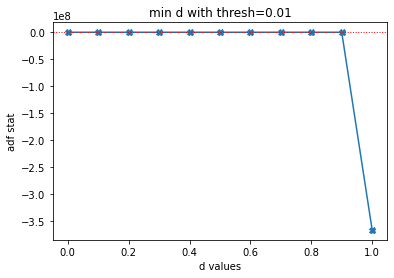

In [21]:
fig,ax=plt.subplots()
out['adfStat'].plot(ax=ax, marker='X')
ax.axhline(out['95% conf'].mean(),lw=1,color='r',ls='dotted')
ax.set_title('min d with thresh=0.01')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');


In [22]:
out

,adfStat,pVal,lags,nObs,95% conf
0.0,5.537228e+00,1.000000e+00,1.0,9997.0,-2.861829
0.1,1.107745e+01,1.000000e+00,1.0,3476.0,-2.862372
0.2,-3.810619e+01,0.000000e+00,1.0,4733.0,-2.862151
0.3,-1.615312e+01,4.547467e-29,1.0,6751.0,-2.861968
0.4,-5.019422e+01,0.000000e+00,1.0,8565.0,-2.861878
0.5,-4.575630e+01,0.000000e+00,1.0,9511.0,-2.861844
0.6,-6.308294e+01,0.000000e+00,1.0,9841.0,-2.861834
0.7,-5.851224e+01,0.000000e+00,1.0,9943.0,-2.861831
0.8,-2.560828e+01,0.000000e+00,1.0,9977.0,-2.861830
0.9,-1.177126e+01,1.088561e-21,1.0,9990.0,-2.861829


#### iii) Apply FFD, with $𝜏 = 1E − 5$. For what minimum $d$ value do you get a p-value below 5%?

In [23]:
cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
out = pd.DataFrame(columns=cols)
for d in np.linspace(0,1,11):
    try:
        df0 = fracDiff(s_,d,thres=1e-5)
        df0 = adfuller(df0,maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df0[:4])+[df0[4]['5%']]
    except Exception as e:
        print(f'd: {d}, error: {e}')
        continue

d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


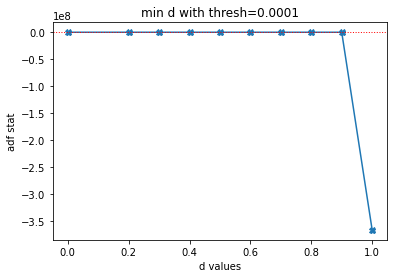

In [24]:
fig,ax=plt.subplots()
out['adfStat'].plot(ax=ax, marker='X')
ax.axhline(out['95% conf'].mean(),lw=1,color='r',ls='dotted')
ax.set_title('min d with thresh=0.0001')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');

In [25]:
out

,adfStat,pVal,lags,nObs,95% conf
0.0,5.537228e+00,1.0,1.0,9997.0,-2.861829
0.2,-4.544005e+01,0.0,1.0,4.0,-4.474365
0.3,-8.920539e+03,0.0,1.0,11.0,-3.189369
0.4,-9.973427e+03,0.0,1.0,27.0,-2.976430
0.5,-8.606326e+03,0.0,1.0,68.0,-2.905087
0.6,-8.345086e+03,0.0,1.0,180.0,-2.877735
0.7,-1.022089e+04,0.0,1.0,513.0,-2.867190
0.8,-1.178766e+04,0.0,1.0,1559.0,-2.863396
0.9,-2.045429e+03,0.0,1.0,4652.0,-2.862161
1.0,-3.665842e+08,0.0,1.0,9996.0,-2.861829


## 3) Take the series from exercise 2.b

In [26]:
s_

,0
0,1.479426
1,2.960605
2,4.443538
3,5.928221
4,7.414652
...,...
9995,10471.274929
9996,10473.272219
9997,10475.269359
9998,10477.266346


### a) Fit the series to a sine function. What is the R-squared?

### b) Apply FFD(d = 1). Fit the series to a sine function. What is the R-squared?

### c) What value of d maximizes the R-squared of a sinusoidal fit on FFD(d). Why?

## 4) Take the dollar bar series on E-mini S&P 500 futures. Using the code in Snippet 5.3, for some d ∈ [0, 2], compute `fracDiff_FFD(fracDiff_FFD(series,d),-d)`. What do you get? Why?

In [6]:
df = pd.read_csv("../data/BTCUSDT-volume-bars.csv", index_col=0, parse_dates=True)
df = df[-1_000_000:]

In [7]:
df.head()

,open,high,low,close,volume
time,,,,,
2021-04-23 06:55:23.894,48803.56,48803.56,48800.00,48800.00,5.824023
2021-04-23 06:55:23.895,48800.00,48800.00,48800.00,48800.00,6.147540
2021-04-23 06:55:23.898,48800.00,48800.00,48800.00,48800.00,6.147540
2021-04-23 06:55:25.319,48800.00,48800.00,48786.36,48795.23,5.029507
2021-04-23 06:55:29.496,48795.22,48819.32,48795.22,48814.42,5.231444


In [8]:
d = 0.5
sel = df[["close"]].iloc[:10000]
fdffd1 = fracDiff_FFD(sel, d)

starting close in Index(['close'], dtype='object')
inner loop: starting range(926, 10000)


<ipython-input-4-2b6b2caf3209>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_=pd.Series()


Finished inner loop


In [9]:
fdffd1

,close
2021-04-23 07:37:12.965,892.857877
2021-04-23 07:37:14.380,890.145290
2021-04-23 07:37:15.655,896.323079
2021-04-23 07:37:19.717,871.447096
2021-04-23 07:37:21.473,820.695960
...,...
2021-04-23 17:37:46.391,896.663185
2021-04-23 17:37:54.329,939.095673
2021-04-23 17:38:06.281,919.359919
2021-04-23 17:38:27.151,948.211760


In [ ]:
val = fracDiff_FFD(fdffd1, -d) # Never finishes don't run
val

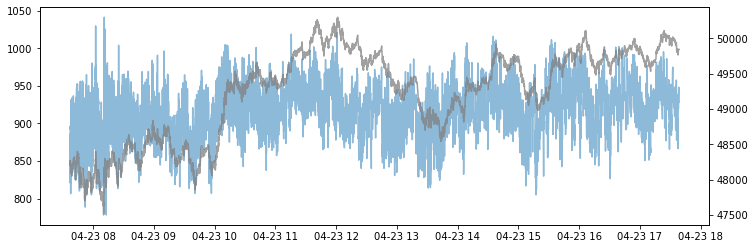

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(fdffd1, alpha=.5)
ax1 = ax.twinx()
ax1.plot(df.reindex(fdffd1.index).close, color="gray", alpha=.75)

## 5) Take the dollar bar series on E-mini S&P 500 futures.

In [14]:
df

,open,high,low,close,volume
time,,,,,
2021-04-23 06:55:23.894,48803.56,48803.56,48800.00,48800.00,5.824023
2021-04-23 06:55:23.895,48800.00,48800.00,48800.00,48800.00,6.147540
2021-04-23 06:55:23.898,48800.00,48800.00,48800.00,48800.00,6.147540
2021-04-23 06:55:25.319,48800.00,48800.00,48786.36,48795.23,5.029507
2021-04-23 06:55:29.496,48795.22,48819.32,48795.22,48814.42,5.231444
...,...,...,...,...,...
2021-06-19 16:27:04.502,35831.71,35844.86,35831.71,35841.54,5.539350
2021-06-19 16:27:20.667,35841.57,35841.58,35822.03,35823.32,5.033671
2021-06-19 16:27:26.627,35823.32,35833.69,35823.32,35826.83,5.425236


### a) Form a new series as a cumulative sum of log-prices.

In [16]:
x = np.log(df.close).cumsum()
x

time
2021-04-23 06:55:23.894    1.079549e+01
2021-04-23 06:55:23.895    2.159097e+01
2021-04-23 06:55:23.898    3.238646e+01
2021-04-23 06:55:25.319    4.318184e+01
2021-04-23 06:55:29.496    5.397763e+01
                               ...     
2021-06-19 16:27:04.502    1.064698e+07
2021-06-19 16:27:20.667    1.064699e+07
2021-06-19 16:27:26.627    1.064700e+07
2021-06-19 16:27:44.405    1.064701e+07
2021-06-19 16:27:48.270    1.064702e+07
Name: close, Length: 1000000, dtype: float64

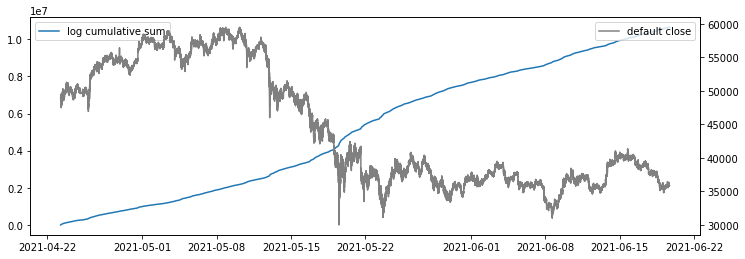

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, label="log cumulative sum")
ax1 = ax.twinx()
ax1.plot(df.close, label="default close", color="gray")
ax.legend()
ax1.legend()

### b) Apply FFD, with 𝜏 = 1E − 5. Determine for what minimum d ∈ [0, 2] the new series is stationary.

In [29]:
def get_optimal_ffd(ds, x, t=1e-5):
    
    cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
    out = pd.DataFrame(columns=cols)
    
    for d in ds:
        print(f"doing {d} in {ds}")
        try:
            #dfx = fracDiff(x.to_frame(),d,thres=1e-5)
            dfx = fracDiff_FFD(x.to_frame(),d,thres=t)
            dfx = adfuller(dfx['close'], maxlag=1,regression='c',autolag=None)
            out.loc[d]=list(dfx[:4])+[dfx[4]['5%']]
        except Exception as e:
            print(f'{d} error: {e}')
            break
    return out

In [30]:
ds = [0.25,0.5,1,1.5,1.8,1.9,1.999,2]
thres = 1e-5
out = get_optimal_ffd(ds, df.close[-10000:], thres) # takes 15 minutes to run on ~44k points

doing 0.25 in [0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.999, 2]
starting close in Index(['close'], dtype='object')
inner loop: starting range(2803, 10000)


<ipython-input-4-2b6b2caf3209>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_=pd.Series()


Finished inner loop
doing 0.5 in [0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.999, 2]
starting close in Index(['close'], dtype='object')
inner loop: starting range(926, 10000)


<ipython-input-4-2b6b2caf3209>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_=pd.Series()


Finished inner loop
doing 1 in [0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.999, 2]
starting close in Index(['close'], dtype='object')
inner loop: starting range(1, 10000)


<ipython-input-4-2b6b2caf3209>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_=pd.Series()


Finished inner loop
doing 1.5 in [0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.999, 2]
starting close in Index(['close'], dtype='object')
inner loop: starting range(71, 10000)


<ipython-input-4-2b6b2caf3209>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_=pd.Series()


Finished inner loop
doing 1.8 in [0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.999, 2]
starting close in Index(['close'], dtype='object')
inner loop: starting range(41, 10000)


<ipython-input-4-2b6b2caf3209>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_=pd.Series()


Finished inner loop
doing 1.9 in [0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.999, 2]
starting close in Index(['close'], dtype='object')
inner loop: starting range(30, 10000)


<ipython-input-4-2b6b2caf3209>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_=pd.Series()


Finished inner loop
doing 1.999 in [0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.999, 2]
starting close in Index(['close'], dtype='object')
inner loop: starting range(6, 10000)


<ipython-input-4-2b6b2caf3209>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_=pd.Series()


Finished inner loop
doing 2 in [0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.999, 2]
starting close in Index(['close'], dtype='object')
inner loop: starting range(2, 10000)


<ipython-input-4-2b6b2caf3209>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_=pd.Series()


Finished inner loop


In [31]:
out

,adfStat,pVal,lags,nObs,95% conf
0.250,-7.119324,3.758286e-10,1.0,7195.0,-2.861942
0.500,-23.507270,0.000000e+00,1.0,9072.0,-2.861859
1.000,-68.717427,0.000000e+00,1.0,9997.0,-2.861829
1.500,-98.576022,0.000000e+00,1.0,9927.0,-2.861831
1.800,-113.214458,0.000000e+00,1.0,9957.0,-2.861830
1.900,-117.749649,0.000000e+00,1.0,9968.0,-2.861830
1.999,-122.165490,0.000000e+00,1.0,9992.0,-2.861829
2.000,-122.227629,0.000000e+00,1.0,9996.0,-2.861829


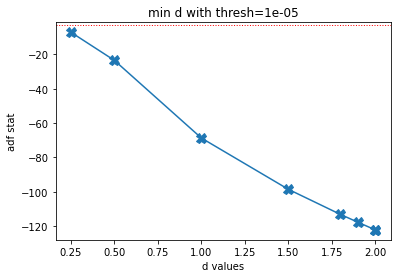

In [32]:
fig,ax=plt.subplots()
out['adfStat'].plot(ax=ax, marker="X", markersize=10)
ax.axhline(out['95% conf'].mean(),lw=1,color='r',ls='dotted')
ax.set_title(f'min d with thresh={thres}')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');

In [34]:
min_ffd = out[out.pVal < 0.05].iloc[0].name
min_ffd

0.25

### c) Compute the correlation of the fracdiff series to the original (untransformed) series.

In [47]:
dfx2 = fracDiff_FFD(df.close.to_frame()[-100000:],min_ffd,thres=thres)

starting close in Index(['close'], dtype='object')
inner loop: starting range(2803, 100000)


<ipython-input-4-2b6b2caf3209>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_=pd.Series()


Finished inner loop


In [48]:
joined = dfx2.join(x.rename('original'), how='left') 
joined.corr()

,close,original
close,1.000000,-0.574866
original,-0.574866,1.000000


### d) Apply Engel-Granger cointegration test on the original and fracdiff series. Are they cointegrated? Why?

In [49]:
coint(joined.close, joined.original)

(-5.012031129764905,
 0.00015645703907095907,
 array([-3.89655268, -3.33619286, -3.04449364]))

### e) Apply a Jarque-Bera normality test on the fracdiff series.

In [50]:
stats.jarque_bera(dfx2)

Jarque_beraResult(statistic=5107.5148398968, pvalue=0.0)

## Plotting

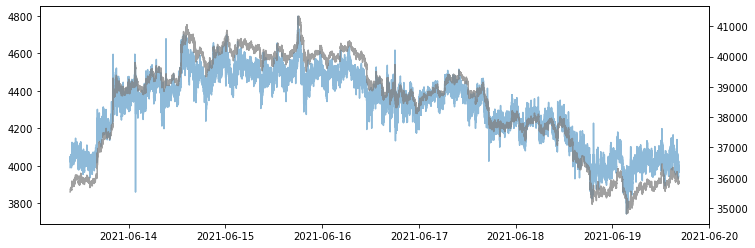

In [51]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(dfx2, alpha=.5)
ax1 = ax.twinx()
ax1.plot(df.reindex(dfx2.index).close, color="gray", alpha=.75)